In [1]:
# STUDENT NAME: Zilong Wang, Ruohan Wang
# STUDENT ID: 260823366, 260911138
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import scipy.sparse
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

np.random.seed(1234)
random.seed(1234)

In [2]:
# docs = scipy.sparse.load_npz('matrix/n_dw.npz').toarray()
# alpha = scipy.sparse.load_npz('matrix/alpha_dk_flattened.npz').toarray()
# with open('matrix/icd_phecode_map.pkl', 'rb') as f5:
#     icd_phecode_map = pickle.load(f5)

In [3]:
docs = scipy.sparse.load_npz('matrix2/n_dw.npz').toarray()
alpha = scipy.sparse.load_npz('matrix2/alpha_dk_flattened.npz').toarray()
with open('matrix2/icd_phecode_map.pkl', 'rb') as f5:
    icd_phecode_map = pickle.load(f5)

In [4]:
# when there is no subtopics, only Phecodes as topics
alpha_M1 = scipy.sparse.load_npz('matrix2/alpha_M1.npz').toarray()

In [95]:
alpha_M4 = scipy.sparse.load_npz('matrix2/alpha_M4.npz').toarray()

In [96]:
np.isnan(alpha_M4).any()

False

In [6]:
## if not works well, try using GPU for more memory and faster speed...

class MixEHR_Nest(object):
    def __init__(self, docs, num_topics, alpha, beta, iteration, perp=False, num_sub_topics=1, 
                topic_word_count=None, topic_count=None, phi=None):
        self.iteration = iteration
        self.D = docs.shape[0]
        self.V = docs.shape[1] 
        self.K = num_topics
        self.M = num_sub_topics # MINIMUM 1 SUBTOPICS, WHICH IS EQUAL TO NO SUBTOPICS
        
        self.alpha = alpha
        self.beta = beta
        
        self.documents = {}
        for i, doc in enumerate(docs):
            tmp = []
            for j, word_freq in enumerate(doc):
                if(word_freq==0):
                    continue
                while(word_freq!=0):
                    tmp.append(j)
                    word_freq -=1
            self.documents[i] = tmp
            random.shuffle(self.documents[i])
        
        self.topic_assignment = {} 
        
        
        if perp:
            ## n_wk.T
            self.topic_word_count = topic_word_count
            ##n_k
            self.topic_count = topic_count
            self.phi = phi
        else:
            self.topic_word_count = np.zeros([self.K, self.V])
            self.topic_count = np.zeros(self.K)
            self.phi = np.zeros([self.K, self.V])
            
        ##n_dk
        self.document_topic_count = np.zeros([self.D, self.K])
        self.num_document = np.zeros(self.D)
        
        self.theta = np.zeros([self.D, self.K])
        
        # for calculating perplexity score, only need to initialize 
        self.perp_theta = np.zeros([self.D, self.K])
        self.perp_topic_assignment = {} 
        self.perp_document_topic_count = np.zeros([self.D, self.K])
        
    def initialization(self):
        print("# of DOCS:", self.D)                            
        print("# of TOPICS:", self.K)
        print("# of SUBTOPICS:", self.M)
        print("# of VOCABS:", self.V)

        ## initialization
        for doc_idx, doc in tqdm.tqdm(enumerate(self.documents)):

            # because we know which Phecode each icd belongs to, we can just first locate their idx in 1623 phecoe, and then randomly assign 
            # one of the three subtopics to it.
            words = self.documents[doc]

            #match the word to phecode idx
            patient_phecode_array = icd_phecode_map[words]

            random_topics = [np.random.randint(phecode_idx*self.M, phecode_idx*self.M + self.M, size=1)[0] for phecode_idx in patient_phecode_array]
            
            self.topic_assignment[doc_idx] = random_topics
            for word_idx, word in enumerate(self.documents[doc]):
                random_topic = random_topics[word_idx]
                self.topic_word_count[random_topic,word] += 1
                self.document_topic_count[doc_idx,random_topic] += 1 
                self.topic_count[random_topic] += 1
#                 self.num_document[doc_idx] += 1
        print("Finish Initialization.")
        
    def Gibbs_sampling(self, folder): 
        ## Collapsed Gibbs Sampling
        with tqdm.tqdm(total = self.iteration) as pbar:
            for i in range(self.iteration):
                for doc_idx, doc in enumerate(self.documents):
                    for word_idx, word in enumerate(self.documents[doc]):
                        z = self.topic_assignment[doc_idx][word_idx]              
                        self.topic_word_count[z,word] -= 1
                        self.document_topic_count[doc_idx, z] -= 1
                        self.topic_count[z] -= 1
#                         self.num_document[doc_idx] -= 1
                        
                        gamma_id = (self.alpha[doc_idx] + self.document_topic_count[doc_idx]) * ((self.beta + self.topic_word_count[:, word]) / (self.beta * self.V + self.topic_count))
                        prob_zid = gamma_id / np.sum(gamma_id)
                        new_z = np.random.choice(self.K, p=prob_zid)
                        
#                         p_z = (self.alpha[doc_idx] + self.document_topic_count[doc_idx]) / \
#                         (np.sum(self.alpha[doc_idx]) + self.num_document[doc_idx]) * \
#                         ((self.beta + self.topic_word_count[:, word]) \
#                         / (self.beta * self.V + self.topic_count))
                        
#                         new_z = np.random.multinomial(1, p_z / np.sum(p_z)).argmax()

                        self.topic_assignment[doc_idx][word_idx] = new_z
                        self.topic_word_count[new_z,word] += 1
                        self.document_topic_count[doc_idx, new_z] += 1
                        self.topic_count[new_z] += 1
#                         self.num_document[doc_idx]+= 1
                        
                ## normalization phi and theta
                for k in range(self.K):
                    self.phi[k] = (self.beta + self.topic_word_count[k]) / (self.beta * self.V + self.topic_count[k])
                for d in range(self.D):
                    self.theta[d] = (self.alpha[d] + self.document_topic_count[d]) / (np.sum(self.document_topic_count[d]) + np.sum(self.alpha[d]))
                pbar.update(1)
        print("Finish Training.")
        phi_mtx_path = folder + '/phi_mtx_iter' + str(self.iteration) + '.pkl'
        theta_mtx_path = folder + '/theta_mtx_iter' + str(self.iteration) + '.pkl'
        with open(phi_mtx_path, 'wb') as f:
            pickle.dump(self.phi, f)
        with open(theta_mtx_path, 'wb') as f:
            pickle.dump(self.theta, f)
        
    def intialization_perplexity(self):
        print('Reinitialize for perplexity calculation, keeping Phi untoched')
        print("# of DOCS:", self.D)                            
        print("# of TOPICS:", self.K)
        print("# of SUBTOPICS:", self.M)
        print("# of VOCABS:", self.V)

        ## initialization
        for doc_idx, doc in tqdm.tqdm(enumerate(self.documents)):

            # because we know which Phecode each icd belongs to, we can just first locate their idx in 1623 phecoe, and then randomly assign 
            # one of the three subtopics to it.
            words = self.documents[doc]

            #match the word to phecode idx
            patient_phecode_array = icd_phecode_map[words]

            random_topics = [np.random.randint(phecode_idx*self.M, phecode_idx*self.M + self.M, size=1)[0] for phecode_idx in patient_phecode_array]
            
            self.perp_topic_assignment[doc_idx] = random_topics
            for word_idx, word in enumerate(self.documents[doc]):
                random_topic = random_topics[word_idx]
                self.perp_document_topic_count[doc_idx,random_topic] += 1 

        print("Finish Perplexity Initialization.")
        
    def Gibbs_sampling_perplexity(self, folder):
        with tqdm.tqdm(total = self.iteration) as pbar:
            for i in range(self.iteration):
                for doc_idx, doc in enumerate(self.documents):
                    for word_idx, word in enumerate(self.documents[doc]):
                        z = self.perp_topic_assignment[doc_idx][word_idx]               
                        self.perp_document_topic_count[doc_idx, z] -= 1
                        
                        gamma_id = (self.alpha[doc_idx] + self.document_topic_count[doc_idx]) * ((self.beta + self.topic_word_count[:, word]) / (self.beta * self.V + self.topic_count))
                        prob_zid = gamma_id / np.sum(gamma_id)
                        new_z = np.random.choice(self.K, p=prob_zid)
                        
                        self.perp_topic_assignment[doc_idx][word_idx] = new_z
                        self.perp_document_topic_count[doc_idx, new_z] += 1
                    
                ## normalization perp_theta
                for d in range(self.D):
                    self.perp_theta[d] = (self.alpha[d] + self.perp_document_topic_count[d]) / (np.sum(self.perp_document_topic_count[d]) + np.sum(self.alpha[d]))
                pbar.update(1)
            print("Finish Perplexity Testing.")
            perp_theta_mtx_path = folder + '/perp_theta_mtx_iter' + str(self.iteration) + '.pkl'
            with open(perp_theta_mtx_path, 'wb') as f:
                pickle.dump(self.perp_theta, f)

In [26]:
def perplexity(theta, phi, documents):
        perplexity_score_sum = 0
        for doc_idx, doc in tqdm.tqdm(enumerate(documents)):
            neg_log_p_dw_all_w = 0
            for word_idx, word in enumerate(documents[doc]):
                p_dw = np.sum(theta[doc] * phi[:, word])
                neg_log_p_dw = -np.log(p_dw)
                neg_log_p_dw_all_w += neg_log_p_dw
            perplexity_score_sum += neg_log_p_dw_all_w
        return perplexity_score_sum / len(documents)

In [19]:
docs.shape

(46278, 6239)

In [35]:
# calculate the marginal probability of every ICD = number of documents where ICD i occurs divided by total number of documents
docs_copy = docs.copy()

# make every icd whose count > 1 equal to 1, to simplify probability calculation
docs_copy[docs_copy > 1] = 1

marginal_icd_prob_over_docs = docs_copy.sum(axis=0) / docs_copy.shape[0]


                          

In [55]:
import itertools
co_occurence_matrix = np.zeros((docs.shape[1], docs.shape[1]))
for d in range(docs.shape[0]):
    idx_occured = np.where(docs[d] != 0)[0]
    if len(idx_occured) > 1:
        pair_indices = list(itertools.combinations(idx_occured,2))
        for pair_ind in pair_indices:
            co_occurence_matrix[pair_ind] += 1
icd_co_occur_prob = co_occurence_matrix / docs_copy.shape[0]        

In [88]:
# with OC-Auto-NPMI, 
# as in Lau, J. H., Newman, D. & Baldwin, T. Machine reading tea leaves: automatically evaluating topic coherence and topic model quality,
# as in Modeling electronic health record data using an end-to-end knowledge-graph-informed topic model 
def get_topic_coherence(prob, num_top_ICD=3):
    sorted_idx = np.argsort(-prob, axis=0)
    TC = []
    for k in range(prob.shape[1]):
        sorted_index_k = sorted_idx[:, k]
        TC_k = 0
        for idx, ICD in enumerate(sorted_index_k[:num_top_ICD]):  
            p_ik = marginal_icd_prob_over_docs[ICD]
            tmp = 0
            for other_ICD in sorted_index_k[idx + 1 : num_top_ICD]:
                p_jk = marginal_icd_prob_over_docs[other_ICD]
                p_ijk = icd_co_occur_prob[ICD, other_ICD]
                if p_ijk == 0:
                    tmp += -1
                else:
                    tmp += -1 + ( np.log(p_ik) + np.log(p_jk) ) / np.log(p_ijk)
            TC_k += tmp
        TC.append(TC_k)
    TC = np.mean(TC) * 2 / (num_top_ICD * (num_top_ICD - 1))
    return TC

In [86]:
def get_topic_diversity(prob, K, num_top_ICD=3):
    sorted_idx = np.argsort(-prob, axis=0)
    top_ICD_set_across_topics = set()
    for k in range(K):
        sorted_index_k = sorted_idx[:, k]
        set_k = sorted_index_k[:num_top_ICD]
        top_ICD_set_across_topics = top_ICD_set_across_topics.union(set_k)
    TD = len(top_ICD_set_across_topics) / (K * num_top_ICD)
    return TD

In [102]:

perplexity_curve_one_shot_1iter = []
perplexity_curve_real_1iter = []
TD_10iter = []
TC_10iter = []
for i in range (10):
    # for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for r in [0.3]:
    # here alpha has 3 subtopics
        docs_train, docs_test, alpha_train, alpha_test = train_test_split(docs, alpha_M4, test_size=r, random_state=42)
        
        # one-shot perplexity score
        model = MixEHR_Nest(docs_train, alpha_train.shape[1], alpha_train, beta=0.00001, 
                            iteration=i+1, # we can change number of iterations here, from 1 to 100
                                        # but also need to change the list outside.
                            perp=False,
                            num_sub_topics=4) # change beta from 0.001 to 0.0001
        model.initialization()
        model.Gibbs_sampling('zilong_result4')
        perp_score_one_shot = perplexity(model.theta, model.phi, model.documents)
        perplexity_curve_one_shot_1iter.append(perp_score_one_shot)
        # print('test_size: ' + str(0.2))
        print('iteration: ' + str(i))
        print('Perplexity score one-shot: ' + str(perp_score_one_shot))
        
        # topic diversity
        TD = get_topic_diversity(model.phi.T, alpha_train.shape[1])
        TD_10iter.append(TD)
        print('Topic diversity is: {}'.format(TD))

        # topic coherence
        TC = get_topic_coherence(model.phi.T)
        TC_10iter.append(TC)
        print('Topic coherence is: {}'.format(TC))


        # real perplexity score
        model_perp = MixEHR_Nest(docs_test, alpha_test.shape[1], alpha_test, beta=0.00001, 
                                iteration=i+1, 
                                num_sub_topics=4, 
                                perp=True, topic_word_count=model.topic_word_count, 
                                topic_count=model.topic_count, phi=model.phi)
        model_perp.intialization_perplexity()
        model_perp.Gibbs_sampling_perplexity('zilong_result4')
        perp_score_real = perplexity(model_perp.perp_theta, model_perp.phi, model_perp.documents)
        perplexity_curve_real_1iter.append(perp_score_real)
        
        print('Perplexity score real: ' + str(perp_score_real))

# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4625.91it/s]


Finish Initialization.


100%|██████████| 1/1 [01:39<00:00, 99.66s/it]


Finish Training.


32394it [00:42, 755.16it/s] 


iteration: 0
Perplexity score one-shot: 43.672168800637664
Topic diversity is: 0.22085110704854763
Topic coherence is: -0.9004653666980501
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4827.00it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:42<00:00, 42.68s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:43<00:00, 43.34s/it]
13884it [00:19, 723.49it/s]


Perplexity score real: 42.94634127727027
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4162.78it/s]


Finish Initialization.


100%|██████████| 2/2 [03:21<00:00, 100.93s/it]


Finish Training.


32394it [00:44, 731.61it/s]


iteration: 1
Perplexity score one-shot: 43.58693844066945
Topic diversity is: 0.22811293926467602
Topic coherence is: -0.9068396433344738
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 5230.91it/s]


Finish Perplexity Initialization.


100%|██████████| 2/2 [01:21<00:00, 40.63s/it]

Finish Perplexity Testing.


100%|██████████| 2/2 [01:21<00:00, 40.96s/it]
13884it [00:18, 736.68it/s]


Perplexity score real: 42.88402024776346
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:06, 4846.29it/s]


Finish Initialization.


100%|██████████| 3/3 [05:13<00:00, 104.37s/it]


Finish Training.


32394it [00:46, 690.83it/s]


iteration: 2
Perplexity score one-shot: 43.518707488384074
Topic diversity is: 0.23085516961202518
Topic coherence is: -0.9119299641789153
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4175.25it/s]


Finish Perplexity Initialization.


100%|██████████| 3/3 [02:08<00:00, 42.60s/it]

Finish Perplexity Testing.


100%|██████████| 3/3 [02:09<00:00, 43.02s/it]
13884it [00:19, 694.58it/s]


Perplexity score real: 42.8157360613479
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4199.43it/s]


Finish Initialization.


100%|██████████| 4/4 [06:44<00:00, 101.21s/it]


Finish Training.


32394it [00:46, 699.69it/s]


iteration: 3
Perplexity score one-shot: 43.471732803926976
Topic diversity is: 0.23476538695917124
Topic coherence is: -0.9143185266991035
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4706.01it/s]


Finish Perplexity Initialization.


100%|██████████| 4/4 [02:48<00:00, 41.90s/it]

Finish Perplexity Testing.


100%|██████████| 4/4 [02:49<00:00, 42.27s/it]
13884it [00:19, 694.97it/s]


Perplexity score real: 42.77530502083011
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4203.55it/s]


Finish Initialization.


100%|██████████| 5/5 [08:24<00:00, 101.00s/it]


Finish Training.


32394it [00:47, 680.73it/s]


iteration: 4
Perplexity score one-shot: 43.40967584231299
Topic diversity is: 0.2360857200893764
Topic coherence is: -0.9215293801842025
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4608.35it/s]


Finish Perplexity Initialization.


100%|██████████| 5/5 [03:28<00:00, 41.80s/it]

Finish Perplexity Testing.


100%|██████████| 5/5 [03:29<00:00, 41.94s/it]
13884it [00:19, 704.36it/s]


Perplexity score real: 42.71664683794687
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4482.75it/s]


Finish Initialization.


100%|██████████| 6/6 [10:06<00:00, 101.08s/it]


Finish Training.


32394it [00:46, 699.45it/s]


iteration: 5
Perplexity score one-shot: 43.354463323328766
Topic diversity is: 0.2357810278285598
Topic coherence is: -0.926790889435165
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4876.80it/s]


Finish Perplexity Initialization.


100%|██████████| 6/6 [04:37<00:00, 47.53s/it]

Finish Perplexity Testing.


100%|██████████| 6/6 [04:38<00:00, 46.40s/it]
13884it [00:19, 702.30it/s]


Perplexity score real: 42.65847880020467
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:10, 3092.06it/s]


Finish Initialization.


100%|██████████| 7/7 [12:43<00:00, 109.08s/it]


Finish Training.


32394it [00:46, 703.05it/s]


iteration: 6
Perplexity score one-shot: 43.3091966562461
Topic diversity is: 0.23908186065407272
Topic coherence is: -0.9249951159066733
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4496.58it/s]


Finish Perplexity Initialization.


100%|██████████| 7/7 [04:58<00:00, 42.26s/it]

Finish Perplexity Testing.


100%|██████████| 7/7 [04:58<00:00, 42.68s/it]
13884it [00:18, 730.81it/s]


Perplexity score real: 42.61971823204519
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4297.93it/s]


Finish Initialization.


100%|██████████| 8/8 [13:29<00:00, 101.18s/it]


Finish Training.


32394it [00:48, 673.84it/s]


iteration: 7
Perplexity score one-shot: 43.27729986985176
Topic diversity is: 0.23989437334958358
Topic coherence is: -0.9290753619295452
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4691.35it/s]


Finish Perplexity Initialization.


100%|██████████| 8/8 [05:40<00:00, 42.61s/it]

Finish Perplexity Testing.


100%|██████████| 8/8 [05:41<00:00, 42.64s/it]
13884it [00:20, 688.19it/s]


Perplexity score real: 42.592027619762085
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4114.16it/s]


Finish Initialization.


100%|██████████| 9/9 [15:05<00:00, 100.64s/it]


Finish Training.


32394it [00:46, 701.94it/s]


iteration: 8
Perplexity score one-shot: 43.252161837273235
Topic diversity is: 0.24238269347958563
Topic coherence is: -0.9274844183210443
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4648.78it/s]


Finish Perplexity Initialization.


100%|██████████| 9/9 [06:15<00:00, 41.29s/it]

Finish Perplexity Testing.


100%|██████████| 9/9 [06:16<00:00, 41.79s/it]
13884it [00:19, 722.25it/s]


Perplexity score real: 42.57045355406115
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4402.86it/s]


Finish Initialization.


100%|██████████| 10/10 [17:05<00:00, 102.59s/it]


Finish Training.


32394it [00:46, 694.46it/s]


iteration: 9
Perplexity score one-shot: 43.19610530829837
Topic diversity is: 0.24167174487101362
Topic coherence is: -0.9318999771560671
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4158.11it/s]


Finish Perplexity Initialization.


100%|██████████| 10/10 [07:10<00:00, 43.01s/it]

Finish Perplexity Testing.


100%|██████████| 10/10 [07:11<00:00, 43.10s/it]
13884it [00:19, 728.89it/s]

Perplexity score real: 42.519221171834694


In [103]:
perplexity_curve_one_shot_1iter

[43.672168800637664,
 43.58693844066945,
 43.518707488384074,
 43.471732803926976,
 43.40967584231299,
 43.354463323328766,
 43.3091966562461,
 43.27729986985176,
 43.252161837273235,
 43.19610530829837]

In [104]:
perplexity_curve_real_1iter

[42.94634127727027,
 42.88402024776346,
 42.8157360613479,
 42.77530502083011,
 42.71664683794687,
 42.65847880020467,
 42.61971823204519,
 42.592027619762085,
 42.57045355406115,
 42.519221171834694]

Text(0.5, 1.0, 'MixEHR-Nest, M=4, testsize=0.3, 1-10 iterations')

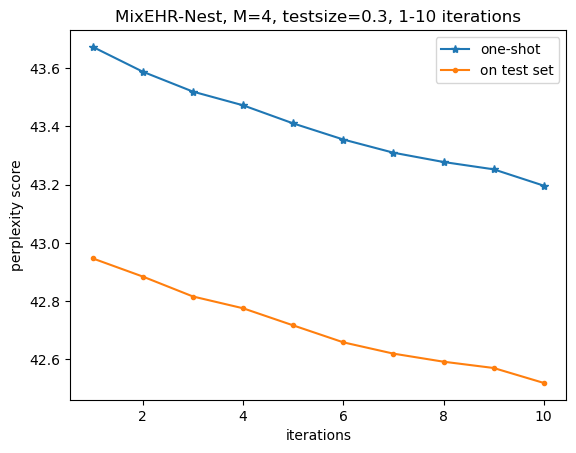

In [106]:
# plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], perplexity_curve_one_shot_5iter[:9], label='one-shot 5iter', marker='^')
# plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], perplexity_curve_real_5iter[:9], label='on test set 5iter', marker='<')
# plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], perplexity_curve_one_shot_1iter, label='one-shot 1iter', marker='*')
# plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], perplexity_curve_real_1iter, label='on test set 1iter', marker='.')
plt.plot([1, 2, 3, 4, 5,6,7,8,9,10], perplexity_curve_one_shot_1iter, label='one-shot', marker='*')
plt.plot([1, 2, 3, 4, 5,6,7,8,9,10], perplexity_curve_real_1iter, label='on test set', marker='.')
plt.legend()
# plt.xlabel('test size')
plt.xlabel('iterations')
plt.ylabel('perplexity score')
# plt.title('MixEHR-Nest, 1 vs 5 iteration')
plt.title('MixEHR-Nest, M=4, testsize=0.3, 1-10 iterations')

Text(0.5, 1.0, 'MixEHR-Nest, M=4, test_size=0.3, 1-10 iterations')

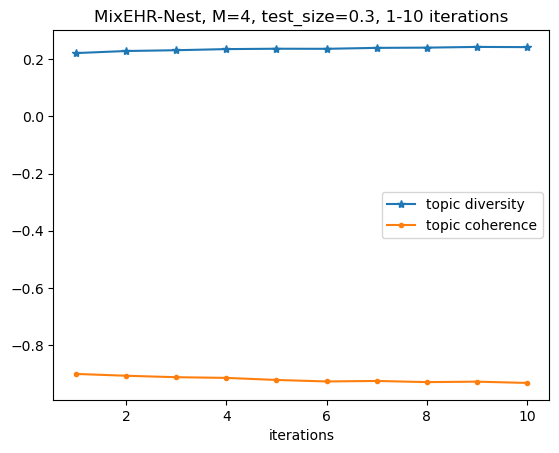

In [107]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], TD_10iter, label='topic diversity', marker='*')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], TC_10iter, label='topic coherence', marker='.')
plt.legend()
# plt.xlabel('test size')
plt.xlabel('iterations')
# plt.ylabel('perplexity score')
# plt.title('MixEHR-Nest, 1 vs 5 iteration')
plt.title('MixEHR-Nest, M=4, test_size=0.3, 1-10 iterations')

In [125]:
five_fold_perplexity_one_shot = []
five_fold_perplexity_real = []
five_fold_train_indices = []
five_fold_test_indices = []
fivefold_TD = []
fivefold_TC = []


# here I only have 5 different random states of train_test_split, still 1 iteration
for i in range(5):
    docs_train, docs_test, alpha_train, alpha_test, train_indices, test_indices = train_test_split(docs, alpha_M4, np.arange(alpha_M4.shape[0]), test_size=0.3,
                                                                                                    random_state=i)
    
    five_fold_train_indices.append(train_indices)
    five_fold_test_indices.append(test_indices)
    
    # one-shot perplexity score
    model = MixEHR_Nest(docs_train, alpha_train.shape[1], alpha_train, beta=0.00001, iteration=1, perp=False,
                        num_sub_topics=4) # change beta from 0.001 to 0.0001
    model.initialization()
    model.Gibbs_sampling('zilong_result4')
    perp_score_one_shot = perplexity(model.theta, model.phi, model.documents)
    five_fold_perplexity_one_shot.append(perp_score_one_shot)
    print('test_size: ' + str(0.2))
    print('Perplexity score one-shot: ' + str(perp_score_one_shot))
    
    # topic diversity
    TD = get_topic_diversity(model.phi.T, alpha_train.shape[1])
    fivefold_TD.append(TD)
    print('Topic diversity is: {}'.format(TD))

    # topic coherence
    TC = get_topic_coherence(model.phi.T)
    fivefold_TC.append(TC)
    print('Topic coherence is: {}'.format(TC))
    
    # real perplexity score
    model_perp = MixEHR_Nest(docs_test, alpha_test.shape[1], alpha_test, beta=0.00001, iteration=1, num_sub_topics=4, 
                             perp=True, topic_word_count=model.topic_word_count, 
                             topic_count=model.topic_count, phi=model.phi)
    model_perp.intialization_perplexity()
    model_perp.Gibbs_sampling_perplexity('zilong_result4')
    perp_score_real = perplexity(model_perp.perp_theta, model_perp.phi, model_perp.documents)
    five_fold_perplexity_real.append(perp_score_real)
    
    print('Perplexity score real: ' + str(perp_score_real))

# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4086.14it/s]


Finish Initialization.


100%|██████████| 1/1 [01:43<00:00, 103.32s/it]


Finish Training.


32394it [00:47, 687.80it/s]


test_size: 0.2
Perplexity score one-shot: 43.11613645187994
Topic diversity is: 0.22064797887466991
Topic coherence is: -0.8998947487835159
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4609.82it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:43<00:00, 43.41s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:44<00:00, 44.22s/it]
13884it [00:20, 676.58it/s]


Perplexity score real: 44.298925293336815
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4378.02it/s]


Finish Initialization.


100%|██████████| 1/1 [01:42<00:00, 102.95s/it]


Finish Training.


32394it [00:46, 697.78it/s]


test_size: 0.2
Perplexity score one-shot: 43.24531762125182
Topic diversity is: 0.2225269144830388
Topic coherence is: -0.9015134271243365
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4506.55it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:43<00:00, 43.36s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:44<00:00, 44.06s/it]
13884it [00:20, 677.93it/s]


Perplexity score real: 43.967705790774524
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:06, 4641.27it/s]


Finish Initialization.


100%|██████████| 1/1 [01:41<00:00, 101.23s/it]


Finish Training.


32394it [00:45, 714.22it/s]


test_size: 0.2
Perplexity score one-shot: 43.10458959794749
Topic diversity is: 0.2213081454397725
Topic coherence is: -0.900854464724755
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4163.88it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:43<00:00, 43.05s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:43<00:00, 43.76s/it]
13884it [00:20, 676.62it/s]


Perplexity score real: 44.26218063844904
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4194.29it/s]


Finish Initialization.


100%|██████████| 1/1 [01:40<00:00, 100.41s/it]


Finish Training.


32394it [00:47, 685.52it/s]


test_size: 0.2
Perplexity score one-shot: 43.04026973419691
Topic diversity is: 0.22156205565711964
Topic coherence is: -0.8976630693791637
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:03, 4621.94it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:42<00:00, 42.43s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:43<00:00, 43.14s/it]
13884it [00:20, 685.74it/s]


Perplexity score real: 44.47924546433449
# of DOCS: 32394
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


32394it [00:07, 4469.71it/s]


Finish Initialization.


100%|██████████| 1/1 [01:38<00:00, 98.40s/it]


Finish Training.


32394it [00:46, 692.62it/s]


test_size: 0.2
Perplexity score one-shot: 42.88242553258988
Topic diversity is: 0.22064797887466991
Topic coherence is: -0.9033980145653829
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 13884
# of TOPICS: 6564
# of SUBTOPICS: 4
# of VOCABS: 6239


13884it [00:02, 4818.38it/s]


Finish Perplexity Initialization.


100%|██████████| 1/1 [00:43<00:00, 43.01s/it]

Finish Perplexity Testing.


100%|██████████| 1/1 [00:43<00:00, 43.69s/it]
13884it [00:20, 686.78it/s]

Perplexity score real: 44.828441227826616


In [126]:
five_fold_perplexity_one_shot

[43.11613645187994,
 43.24531762125182,
 43.10458959794749,
 43.04026973419691,
 42.88242553258988]

In [127]:
five_fold_perplexity_real

[44.298925293336815,
 43.967705790774524,
 44.26218063844904,
 44.47924546433449,
 44.828441227826616]

In [112]:
five_fold_train_indices

[array([18277, 46157, 44795, ..., 42613, 43567,  2732]),
 array([40786,  1856, 19902, ...,  5192, 12172, 33003]),
 array([  774, 12983, 26095, ...,  6637, 35343, 23720]),
 array([42991, 24483,  6117, ..., 11513,  1688,  5994]),
 array([43358, 28704, 25485, ..., 27063,  8366, 17530])]

In [14]:
def select_top_ICD(prob, vocab, selected_topics, folder, num_top_ICD = 3):
    K = len(selected_topics)
    sns.set(rc={'figure.figsize':(5,8)})
    top_ICD_topic = np.zeros((num_top_ICD * K, K))
    top_code_list = []
    binary_indicator = []
    sorted_idx = np.argsort(-prob, axis=0)
    for k in range(K):
        sorted_index_k = sorted_idx[:, k]
        for idx, ICD in enumerate(sorted_index_k[:num_top_ICD]): 
            top_code_list.append(vocab[ICD])
            if icd_phecode_map[ICD] * 3 == selected_topics[k] - (k % num_top_ICD):
                binary_indicator.append(1)
            else:
                binary_indicator.append(0)
   
            top_ICD_topic[idx + k * num_top_ICD] = prob[ICD]
            
    top_ICD_topic /= np.sum(top_ICD_topic, axis=0)
    binary_indicator = np.array(binary_indicator)[:, np.newaxis]
    sns.set(font_scale=0.8)
    
    f, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0, 'width_ratios': [1, K]})
    
    sns.heatmap(binary_indicator, linewidths=.1, 
                cmap='Blues', xticklabels=False, yticklabels=False, ax=axs[0], cbar=False)
    axs[1].tick_params(left=False, right=True, labelright=True, labelleft=False, labelrotation=0)
    sns.heatmap(top_ICD_topic, 
                cmap='OrRd',
                xticklabels= ["Schizophrenia-1", "Schizophrenia-2", "Schizophrenia-3",
                              "CHF-1", "CHF-2", "CHF-3",
                              "Type 1 Diabetes-1","Type 1 Diabetes-2","Type 1 Diabetes-3",
                              "Asthma-1","Asthma-2","Asthma-3"],
                yticklabels=top_code_list, 
                linewidths=.1, ax=axs[1], cbar=False)#,cbar_kws={"shrink": 0.5, 'location': 'left'})
    plt.savefig(folder + '/lda_result.png', dpi=200, bbox_inches='tight')
    plt.show()

In [15]:
with open ('matrix2/vocab_idx_map.pkl', 'rb') as f1:
    vocab_idx_meta = pickle.load(f1)
with open('matrix2/idx_vocab_map.pkl', 'rb') as f2:
    idx_vocab_meta = pickle.load(f2)
with open('matrix2/patient_idx_map.pkl', 'rb') as f3:
    patient_idx_meta = pickle.load(f3)
with open('matrix2/idx_patient_map.pkl', 'rb') as f4:
    idx_patient_meta = pickle.load(f4)
with open('matrix2/phecode_list.pkl', 'rb') as f5:
    PheCode = pickle.load(f5)

In [16]:
## PheCode list
#{295.1: "Schizophrenia", 428.1: "Congestive heart failure (CHF)",250.1: "Type 1 Diabetes",495: "Asthma"}

ICD_meta = pd.read_csv("D_ICD_DIAGNOSES.csv.gz", header=0)
ICD_meta = ICD_meta[['ICD9_CODE','SHORT_TITLE']]
# ICD_meta['ICD9_CODE'] = ICD_meta['ICD9_CODE'].str.lstrip('0')
ICD_meta['Compound_ID'] = ICD_meta['ICD9_CODE'] + "-" + ICD_meta['SHORT_TITLE']

ICD_topic_prob = model.phi.T
ICD_list = list(range(ICD_topic_prob.shape[0]))
ICD_code_list = [idx_vocab_meta[key] for key in ICD_list]

In [17]:
vocab = []   
for key in ICD_code_list:
    value = ICD_meta[ICD_meta['ICD9_CODE'] == str(key).replace('.','')]['Compound_ID'].tolist()
    if value == []:
        value = [str(key)] 
    vocab.append(value[0])

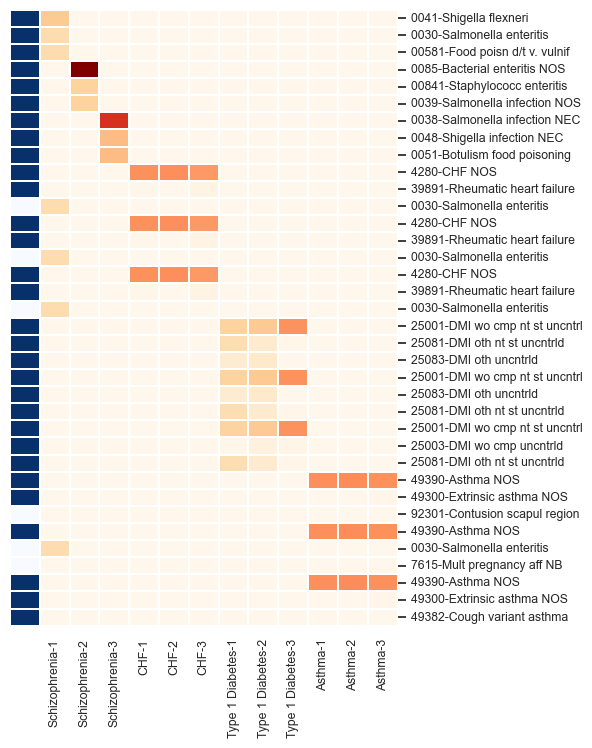

In [143]:
## Get index (including subtopics) of selected PheCode
topics = [8.5, 428.1, 250.1, 495]
# topics = [250.2]
phecode_idx = [np.where(PheCode==selected)[0][0] for selected in topics]
selected_topics = []
for topic_idx in phecode_idx:
    sub_topics = [3 * topic_idx, 3 * topic_idx+1, 3 * topic_idx+2]
    selected_topics.extend(sub_topics)
    
# topics = [295.1, 428.1, 250.2, 495]


select_top_ICD(model.phi.T[:,selected_topics], vocab, selected_topics, 'zilong_result4')

In [225]:
# LDA
# class LDA(object):
#     def __init__(self, docs, num_topics, alpha, beta, iteration, perp=False, 
#                 topic_word_count=None, topic_count=None, phi=None):
#         self.iteration = iteration
#         self.D = docs.shape[0]
#         self.V = docs.shape[1] 
#         self.K = num_topics 
        
#         self.alpha = np.ones(self.K)
#         self.beta = beta
        
#         self.documents = {}
#         for i, doc in enumerate(docs):
#             tmp = []
#             for j, word_freq in enumerate(doc):
#                 if(word_freq==0):
#                     continue
#                 while(word_freq!=0):
#                     tmp.append(j)
#                     word_freq -=1
#             self.documents[i] = tmp
#             random.shuffle(self.documents[i])
        
#         self.topic_assignment = {} 
# #         ## n_wk.T
# #         self.topic_word_count = np.zeros([self.K, self.V])
# #         ##n_dk
# #         self.document_topic_count = np.zeros([self.D, self.K]) 
# #         ##n_k
# #         self.topic_count = np.zeros(self.K)
        
        
# #         self.phi = np.zeros([self.K, self.M])
# #         self.theta = np.zeros([self.D, self.K])
        
#         if perp:
#             ## n_wk.T
#             self.topic_word_count = topic_word_count
#             ##n_k
#             self.topic_count = topic_count
#             self.phi = phi
#         else:
#             self.topic_word_count = np.zeros([self.K, self.V])
#             self.topic_count = np.zeros(self.K)
#             self.phi = np.zeros([self.K, self.V])
            
#         ##n_dk
#         self.document_topic_count = np.zeros([self.D, self.K])
        
        
#         self.theta = np.zeros([self.D, self.K])
        
#         # for calculating perplexity score, only need to initialize 
#         self.perp_theta = np.zeros([self.D, self.K])
#         self.perp_topic_assignment = {} 
#         self.perp_document_topic_count = np.zeros([self.D, self.K])

        
#         ##words per document
#         self.num_document = np.zeros(self.D)
        
#         print("# of DOCS:", self.D)                            
#         print("# of TOPICS:", self.K)
#         print("# of VOCABS:", self.V)
        
#         ## initialization
#         for doc_idx, doc in enumerate(self.documents):
#             random_topics = np.random.randint(0, self.K, size=len(self.documents[doc]))
#             self.topic_assignment[doc_idx] = random_topics
#             for word_idx, word in enumerate(self.documents[doc]):
#                 random_topic = random_topics[word_idx]
#                 self.topic_word_count[random_topic, word] += 1
#                 self.document_topic_count[doc_idx, random_topic] += 1 
#                 self.topic_count[random_topic] += 1
#                 self.num_document[doc_idx] += 1
#         print("Finish Initialization.")
        
#     def Gibbs_sampling(self):
#         ## Collapsed Gibbs Sampling
#         with tqdm.tqdm(total = self.iteration) as pbar:
#             for i in range(self.iteration):
#                 for doc_idx, doc in enumerate(self.documents):
#                     for word_idx, word in enumerate(self.documents[doc]):
#                         z = self.topic_assignment[doc_idx][word_idx]              
#                         self.topic_word_count[z,word] -= 1
#                         self.document_topic_count[doc_idx, z] -= 1
#                         self.topic_count[z] -= 1
#                         self.num_document[doc_idx] -= 1

#                         p_z = (self.alpha + self.document_topic_count[doc_idx]) / \
#                         (np.sum(self.alpha) + self.num_document[doc_idx]) * \
#                         ((self.beta + self.topic_word_count[:, word]) \
#                         / (self.beta * self.V + self.topic_count))
#                         new_topic = np.random.multinomial(1, p_z / np.sum(p_z)).argmax()

#                         self.topic_assignment[doc_idx][word_idx] = new_topic
#                         self.topic_word_count[new_topic,word] += 1
#                         self.document_topic_count[doc_idx, new_topic] += 1
#                         self.topic_count[new_topic] += 1
#                         self.num_document[doc_idx]+= 1

#                 ## normalize phi and theta
#                 for k in range(self.K):
#     #                 for w in range(self.V):
#                     self.phi[k] = (self.beta + self.topic_word_count[k] ) / (self.beta * self.V + self.topic_count[k])
#                 for d in range(self.D):
#     #                 for k in range(self.K):
#                     self.theta[d] = (self.document_topic_count[d] + self.alpha)/(self.num_document[d] + np.sum(self.alpha))
#                 pbar.update(1)
#         print("Finish Training.")     
    
#     def intialization_perplexity(self):
#         print('Reinitialize for perplexity calculation, keeping Phi untoched')
#         print("# of DOCS:", self.D)                            
#         print("# of TOPICS:", self.K)
#         print("# of VOCABS:", self.V)

#         ## initialization
#         for doc_idx, doc in tqdm.tqdm(enumerate(self.documents)):
#             random_topics = np.random.randint(0, self.K, size=len(self.documents[doc]))
#             self.perp_topic_assignment[doc_idx] = random_topics
#             for word_idx, word in enumerate(self.documents[doc]):
#                 random_topic = random_topics[word_idx]
#                 self.perp_document_topic_count[doc_idx,random_topic] += 1 

#         print("Finish Perplexity Initialization.")
        
#     def Gibbs_sampling_perplexity(self, folder):
#         with tqdm.tqdm(total = self.iteration) as pbar:
#             for i in range(self.iteration):
#                 for doc_idx, doc in enumerate(self.documents):
#                     for word_idx, word in enumerate(self.documents[doc]):
#                         z = self.perp_topic_assignment[doc_idx][word_idx]              
#                         self.perp_document_topic_count[doc_idx, z] -= 1
#                         self.num_document[doc_idx] -= 1
                        
#                         p_z = (self.alpha + self.document_topic_count[doc_idx]) / \
#                         (np.sum(self.alpha) + self.num_document[doc_idx]) * \
#                         ((self.beta + self.topic_word_count[:, word]) \
#                         / (self.beta * self.V + self.topic_count))
#                         new_topic = np.random.multinomial(1, p_z / np.sum(p_z)).argmax()
                        
#                         self.perp_topic_assignment[doc_idx][word_idx] = new_topic
#                         self.perp_document_topic_count[doc_idx, new_topic] += 1
#                         self.num_document[doc_idx]+= 1
                        
#                 ## normalization perp_theta
#                 for d in range(self.D):
#                     self.perp_theta[d] = (self.alpha + self.perp_document_topic_count[d]) / (np.sum(self.perp_document_topic_count[d]) + np.sum(self.alpha))
#                 pbar.update(1)
#             print("Finish Perplexity Testing.")
#             perp_theta_mtx_path = folder + '/perp_theta_mtx_iter' + str(self.iteration) + '.pkl'
#             with open(perp_theta_mtx_path, 'wb') as f:
#                 pickle.dump(self.perp_theta, f)

In [291]:
# perplexity_curve_one_shot_lda_new = []
# perplexity_curve_real_lda_new = []
# five_fold_train_indices_lda = []
# five_fold_test_indices_lda = []

# for i in range(5):
#     docs_train, docs_test, train_indices, test_indices = train_test_split(docs, np.arange(docs.shape[0]), test_size=0.2, random_state=i)
    
#     five_fold_train_indices_lda.append(train_indices)
#     five_fold_test_indices_lda.append(test_indices)
    
#     # one-shot perplexity score
#     lda = LDA(docs_train, iteration=1, alpha=1, beta=0.00001, num_topics=1641, perp=False)
    
# #     model = MixEHR_Nest(docs_train, alpha_train.shape[1], alpha_train, beta=0.00001, iteration=5, perp=False,
# #                         num_sub_topics=3) # change beta from 0.001 to 0.0001
    
# #     model.initialization()
#     lda.Gibbs_sampling()
#     perp_score_one_shot = perplexity(lda.theta, lda.phi, lda.documents)
#     perplexity_curve_one_shot_lda_new.append(perp_score_one_shot)
#     print('test_size: ' + str(r))
#     print('Perplexity score one-shot LDA: ' + str(perp_score_one_shot))
    
    
#     # real perplexity score
#     lda_perp = LDA(docs_test, iteration=1, alpha=1, beta=0.00001, num_topics=1641, 
#                              perp=True, topic_word_count=lda.topic_word_count, 
#                              topic_count=lda.topic_count, phi=lda.phi)
#     lda_perp.intialization_perplexity()
#     lda_perp.Gibbs_sampling_perplexity('zilong_result4')
#     perp_score_real = perplexity(lda_perp.perp_theta, lda_perp.phi, lda_perp.documents)
#     perplexity_curve_real_lda_new.append(perp_score_real)
    
#     print('Perplexity score real LDA: ' + str(perp_score_real))

    

# of DOCS: 37022
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:54<00:00, 54.21s/it]


Finish Training.


37022it [00:16, 2309.22it/s]


test_size: 0.9
Perplexity score one-shot LDA: 0.00012522248421967055
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239


9256it [00:00, 38404.71it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.17s/it]


Finish Perplexity Testing.


9256it [00:04, 2195.41it/s]


Perplexity score real LDA: 0.025752967652462596
# of DOCS: 37022
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:55<00:00, 55.06s/it]


Finish Training.


37022it [00:16, 2267.84it/s]


test_size: 0.9
Perplexity score one-shot LDA: 0.002403122244145612
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239


9256it [00:00, 31447.78it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.56s/it]


Finish Perplexity Testing.


9256it [00:03, 2317.77it/s]


Perplexity score real LDA: 0.006922188481208291
# of DOCS: 37022
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:59<00:00, 59.55s/it]


Finish Training.


37022it [00:16, 2252.99it/s]


test_size: 0.9
Perplexity score one-shot LDA: 0.0042248836635524626
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239


9256it [00:00, 39352.36it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Finish Perplexity Testing.


9256it [00:04, 2279.73it/s]


Perplexity score real LDA: 0.0005010989042085541
# of DOCS: 37022
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:55<00:00, 55.86s/it]


Finish Training.


37022it [00:15, 2335.33it/s]


test_size: 0.9
Perplexity score one-shot LDA: 0.0014599633042806552
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239


9256it [00:00, 40841.73it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.12s/it]


Finish Perplexity Testing.


9256it [00:03, 2325.61it/s]


Perplexity score real LDA: 0.005374937435318852
# of DOCS: 37022
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:50<00:00, 50.95s/it]


Finish Training.


37022it [00:15, 2358.18it/s]


test_size: 0.9
Perplexity score one-shot LDA: 0.0019308361177103777
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239
Finish Initialization.
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of VOCABS: 6239


9256it [00:00, 42065.66it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]


Finish Perplexity Testing.


9256it [00:04, 2279.75it/s]

Perplexity score real LDA: 0.0023051456957068023


In [262]:
# MixEHR-guided, where we use alpha_M1, no subtopics, 
# because all we need to change is alpha, we just inherit general MixEHR-Nest
five_fold_perplexity_one_shot_M1 = []
five_fold_perplexity_real_M1 = []
five_fold_train_indices_M1 = []
five_fold_test_indices_M1 = []

for i in range(5):
    docs_train, docs_test, alpha_M1_train, alpha_M1_test, train_indices, test_indices = train_test_split(docs, alpha_M1, np.arange(alpha_M1.shape[0]), test_size=0.2, random_state=i)
    
    five_fold_train_indices_M1.append(train_indices)
    five_fold_test_indices_M1.append(test_indices)
    
    # one-shot perplexity score
    model_M1 = MixEHR_Nest(docs_train, alpha_M1_train.shape[1], alpha_M1_train, beta=0.00001, iteration=1, perp=False,
                        num_sub_topics=1) # change beta from 0.001 to 0.0001
    model_M1.initialization()
    model_M1.Gibbs_sampling('zilong_result4')
    perp_score_one_shot_M1 = perplexity(model_M1.theta, model_M1.phi, model_M1.documents)
    five_fold_perplexity_one_shot_M1.append(perp_score_one_shot_M1)
    print('test_size: ' + str(0.2))
    print('Perplexity score one-shot: ' + str(perp_score_one_shot_M1))
    
    
    # real perplexity score
    model_perp = MixEHR_Nest(docs_test, alpha_M1_test.shape[1], alpha_M1_test, beta=0.00001, iteration=1, num_sub_topics=1, 
                             perp=True, topic_word_count=model_M1.topic_word_count, 
                             topic_count=model_M1.topic_count, phi=model_M1.phi)
    model_perp.intialization_perplexity()
    model_perp.Gibbs_sampling_perplexity('zilong_result4')
    perp_score_real = perplexity(model_perp.perp_theta, model_perp.phi, model_perp.documents)
    five_fold_perplexity_real_M1.append(perp_score_real)
    
    print('Perplexity score real: ' + str(perp_score_real))

# of DOCS: 37022
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


37022it [00:08, 4425.30it/s]


Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:44<00:00, 44.89s/it]


Finish Training.


37022it [00:17, 2148.30it/s]


test_size: 0.2
Perplexity score one-shot: 2.6789603512390966e-06
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


9256it [00:01, 4829.22it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.90s/it]


Finish Perplexity Testing.


9256it [00:04, 2191.56it/s]


Perplexity score real: 0.016876871264508205
# of DOCS: 37022
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


37022it [00:07, 5115.63it/s]


Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:43<00:00, 43.16s/it]


Finish Training.


37022it [00:15, 2315.74it/s]


test_size: 0.2
Perplexity score one-shot: 0.0010760930211920873
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


9256it [00:02, 4157.64it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.06s/it]


Finish Perplexity Testing.


9256it [00:04, 2079.24it/s]


Perplexity score real: 0.0030327286613755127
# of DOCS: 37022
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


37022it [00:08, 4534.68it/s]


Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:42<00:00, 42.97s/it]


Finish Training.


37022it [00:16, 2245.05it/s]


test_size: 0.2
Perplexity score one-shot: 0.0023830198393651877
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


9256it [00:01, 5121.58it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Finish Perplexity Testing.


9256it [00:04, 2289.93it/s]


Perplexity score real: 1.0774169662730492e-05
# of DOCS: 37022
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


37022it [00:07, 4769.69it/s]


Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:44<00:00, 44.62s/it]


Finish Training.


37022it [00:16, 2305.60it/s]


test_size: 0.2
Perplexity score one-shot: 0.0006091154434979317
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


9256it [00:01, 5234.81it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.01s/it]


Finish Perplexity Testing.


9256it [00:04, 2254.23it/s]


Perplexity score real: 0.0029038341136637586
# of DOCS: 37022
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


37022it [00:08, 4583.99it/s]


Finish Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:43<00:00, 43.88s/it]


Finish Training.


37022it [00:16, 2246.19it/s]


test_size: 0.2
Perplexity score one-shot: 0.0010622003168698753
Reinitialize for perplexity calculation, keeping Phi untoched
# of DOCS: 9256
# of TOPICS: 1641
# of SUBTOPICS: 1
# of VOCABS: 6239


9256it [00:01, 4973.52it/s]


Finish Perplexity Initialization.


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]


Finish Perplexity Testing.


9256it [00:04, 2271.04it/s]

Perplexity score real: 0.0007592291673685674


In [263]:
five_fold_perplexity_one_shot_M1

[2.6789603512390966e-06,
 0.0010760930211920873,
 0.0023830198393651877,
 0.0006091154434979317,
 0.0010622003168698753]

In [264]:
five_fold_perplexity_real_M1

[0.016876871264508205,
 0.0030327286613755127,
 1.0774169662730492e-05,
 0.0029038341136637586,
 0.0007592291673685674]

([<matplotlib.axis.XTick at 0x7fa771612670>,
 [Text(1, 0, 'one-shot'), Text(2, 0, 'test')])

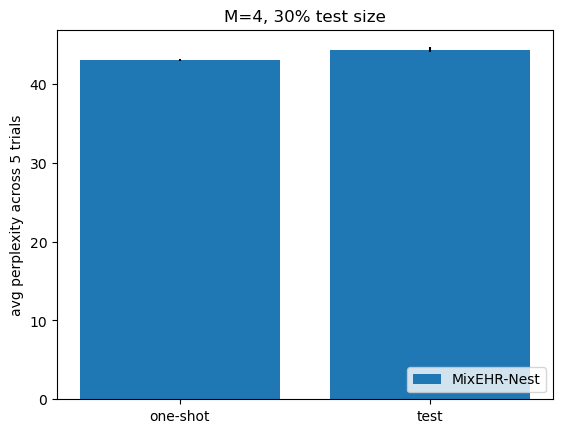

In [129]:
plt.bar(x=[1,2], height=[np.mean(five_fold_perplexity_one_shot), np.mean(five_fold_perplexity_real)], yerr=[np.std(five_fold_perplexity_one_shot), np.std(five_fold_perplexity_real)], label='MixEHR-Nest')
# plt.bar(x=[3,4], height=[np.mean(five_fold_perplexity_one_shot_M1), np.mean(five_fold_perplexity_real_M1)], yerr=[np.std(five_fold_perplexity_one_shot_M1), np.std(five_fold_perplexity_real_M1)], tick_label=['one-shot', 'test'], label='MixEHR-Guided')
# plt.bar(x=[5,6], height=[np.mean(perplexity_curve_one_shot_lda), np.mean(perplexity_curve_real_lda)], yerr=[np.std(perplexity_curve_one_shot_lda), np.std(perplexity_curve_real_lda)], label='LDA-4923 topics')
# plt.bar(x=[7,8], height=[np.mean(perplexity_curve_one_shot_lda_new), np.mean(perplexity_curve_real_lda_new)], yerr=[np.std(perplexity_curve_one_shot_lda), np.std(perplexity_curve_real_lda)], label='LDA-1641 topics')

plt.legend(loc='lower right')
plt.ylabel('avg perplexity across 5 trials')
plt.title('M=4, 30% test size')
# plt.xlabel('left is on train (one-shot), right is on test')
plt.xticks([1,2],['one-shot', 'test'])#, 'one-shot', 'test', 'one-shot', 'test'])

([<matplotlib.axis.XTick at 0x7fa731c103a0>,
 [Text(1, 0, 'TC'), Text(2, 0, 'TD')])

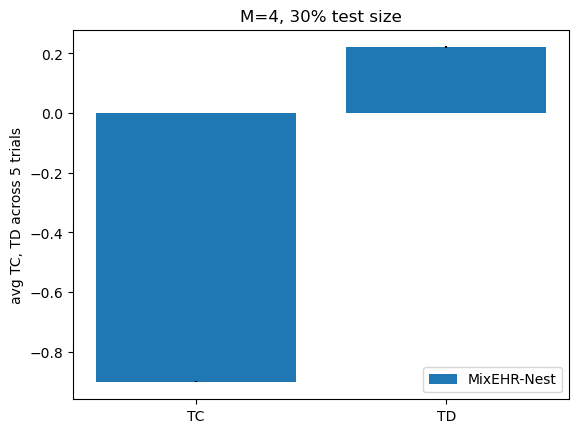

In [131]:
plt.bar(x=[1,2], height=[np.mean(fivefold_TC), np.mean(fivefold_TD)], yerr=[np.std(fivefold_TC), np.std(fivefold_TC)], label='MixEHR-Nest')
plt.legend(loc='lower right')
plt.title('M=4, 30% test size')
plt.ylabel('avg TC, TD across 5 trials')
plt.xticks([1,2],['TC', 'TD'])